In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import cv2

In [2]:
# modifying streamingSVD slightly to do videos

import numpy as np
import scipy

def getSvd(A, k, l1, l, num_iter, decay_alpha=1, silent=True):
    n, s = A.shape
    A_init = A[:, 0:l1]

    Q, R = np.linalg.qr(A_init, mode='reduced')

    t = l1
    
    all_Qs = np.zeros((n, l1, num_iter))
    
    for i in range(0, num_iter):

        if (t >= s):
            t = t-s

        #New data A+
        #If wrapping around, concatenate last and first sections together
        if (t+l >= s):
            A_plus = A[:, t:s]
            tmp = t+l-s
            A_plus = np.append(A_plus, A[:,0:tmp], axis=1)
            t = tmp
        else:
            A_plus = A[:, t:t+l]
            t = t+l
        
        #QR decomposition of additional data
        Q_T = np.transpose(Q)
        R_T = np.transpose(R)
        C = Q_T.dot(A_plus)
        A_perp = A_plus - Q.dot(C)
        Q_perp, R_perp = np.linalg.qr(A_perp, mode='full')

        #Calculate QR decomposition of augmented data matrix, Q_hat, R_hat
        #Q_hat is simple appending of Qi-1 and Q_perp
        #R_hat is based on Figure 3.1 in Baker's thesis
        Q_hat = np.append(Q, Q_perp, axis=1)
        R_prev = np.append(R, C, axis=1)
        tmp = np.zeros((R_perp.shape[0], R.shape[1]))
        tmp = np.append(tmp, R_perp, axis=1)

        R_hat = np.append(R_prev, tmp, axis=0)
        
        #SVD of R_hat (B_hat)
        U, diag, V_T = np.linalg.svd(R_hat, full_matrices=False)
        # decaying (implements forgetting)
        diag = np.power(diag, decay_alpha)
        V = np.transpose(V_T)
        
        #Orthogonal Procrustes singular basis
        M = Q_T.dot(Q_hat) 
        U1 = U[:, 0:k]
        M = M.dot(U1)
        
        #Find U_tilda, V_tilda from SVD of M
        U_tilda, diag_tilda, V_tilda_T = np.linalg.svd(M, full_matrices=False)
        
        #Find T as product of U_tilda, V_tilda
        T = U_tilda.dot(V_tilda_T)
        #Calculate new Q of this iteration using T
        #Q = Q_hat * U1 * T_transpose
        T_trans = np.transpose(T)
        G1 = U1.dot(T_trans)
        G1_T = np.transpose(G1)
        Q = Q_hat.dot(G1)
        
        #Calculation of new R does not need Orthogonal Procrustes since
        #we do not care
        V1 = V[:,0:k]
        G1v, Tv = scipy.linalg.rq(V1)
        Tv_T = np.transpose(Tv)
        #R = G1_T.dot(R_hat.dot(G1v))
        #Simplifying this expression, we get
        #R = G1_T * U * diag(S) * V_T * V * Tv_T
        #R = G1_T * U * diag(S) * Tv_T
        #But G1_T = T * U1_T => R = T * U1_T * U1 * diag(S) * Tv_T
        #R = T * diag(S) * Tv_T
        R = T.dot(np.diag(diag[0:k]).dot(Tv_T))
        ##Orthogonal Procrustes singular basis
        #M = R_T.dot(G1_T.dot(R_hat))
        #V1 = V[:, 0:k]
        #M = M.dot(V1)
        #
        ##Find U_tilda, V_tilda from SVD of M
        #U_tilda, diag_tilda, V_tilda_T = np.linalg.svd(M, full_matrices=False)
        #
        ##Find T as product of U_tilda, V_tilda
        #T = U_tilda.dot(V_tilda_T)
        #
        ##Calculate new R of this iteration using T
        ##R = G_u_Transpose * R_hat * V1 * Tv_transpose
        #T_trans = np.transpose(T)
        #Gv1 = V1.dot(T_trans)
        #R = G1_T.dot(R_hat.dot(Gv1))
        
        all_Qs[:, :, i] = Q
#         U, S, V = np.linalg.svd(R, full_matrices=False)
#         Qtcoll[:, :, i] = Q.dot(U)
        
        
        
        if not silent:
            print('Q_perp shape:\t' + str(Q_perp.shape))
            print('R_perp shape:\t' + str(R_perp.shape))
            print('Aplus shape:\t' + str(A_plus.shape))
            print('R_hat shape:\t' + str(R_hat.shape))
            print('U (Rhat) shape:\t' + str(U.shape))
            print('Q shape :\t' + str(Q.shape))
            print('Qhat shape :\t' + str(Q_hat.shape))
            print('U1 shape:\t' + str(U1.shape))
            print('M shape :\t' + str(M.shape))
            print('T shape :\t' + str(T.shape))
            print('G1 shape:\t' + str(G1.shape))
            print('new Q shape:\t' + str(Q.shape))
            print('R shape:\t' + str(R.shape))
        
    U, S, V = np.linalg.svd(R, full_matrices=False)
    Qtrue = Q.dot(U)

    return all_Qs



In [4]:
# loading video into numpy array in memory

cap = cv2.VideoCapture('input.avi')

# read first frame to get info from it
ret, frame = cap.read()
num_frames = 200
all_frames = np.zeros((int(frame.size/3), num_frames)) # div 3 bc color channels

for i in range(200):  # wait 200 frames to set up video right
    cap.read()

for t in range(num_frames): # now take 200 frames
    ret, frame = cap.read()
    if ret==True:
        cv2.imshow('frame',frame)  # flattening color image to save data
        all_frames[:, t] = np.sum(frame, axis=2).flatten().astype('int16')
    else:
        break

# Release everything
cap.release()
cv2.destroyAllWindows()

In [8]:
%%time

# running video through streamingSVD to get 
# singular subspace estimate through time
k = 1
l1 = 1
l = 1
decay = 1
num_iters = np.ceil((all_frames.shape[1] - l1) / l).astype('int')

all_Qs = getSvd(all_frames, k, l1, l, num_iters, decay_alpha=decay)
# all_Qs = all_Qs.reshape((all_Qs.shape[0], all_Qs.shape[2]))  # starting with init 1

/home/pranjal/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The 'full' option is deprecated in favor of 'reduced'.
For backward compatibility let mode default.


CPU times: user 8.83 s, sys: 11.9 s, total: 20.7 s
Wall time: 2.72 s


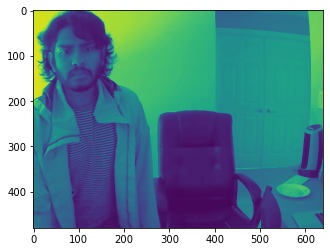

In [7]:
# Display original video
fig = plt.figure()
ims = []
for i in range(num_frames):
    im = plt.imshow(all_frames[:, i].reshape((480, 640)), animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
HTML(ani.to_html5_video())
# ani.save('input.mp4')

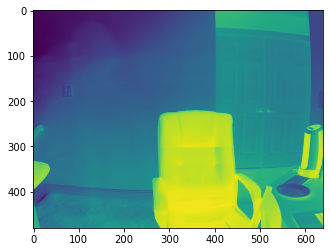

In [6]:
# Display our minimally changing subspace (Qs)
fig = plt.figure()
ims = []
for i in range(num_iters):
    im = plt.imshow(all_Qs[:, 0, i].reshape((480, 640)), animated=True)
    ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
HTML(ani.to_html5_video())
# ani.save('output.mp4')